### Neural Style Transfer

In [162]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import copy

From the paper of NST it requires 2 types of Losses
# 1.   Content Loss
  Calculated the Content loss based on the paper equation Lcontent

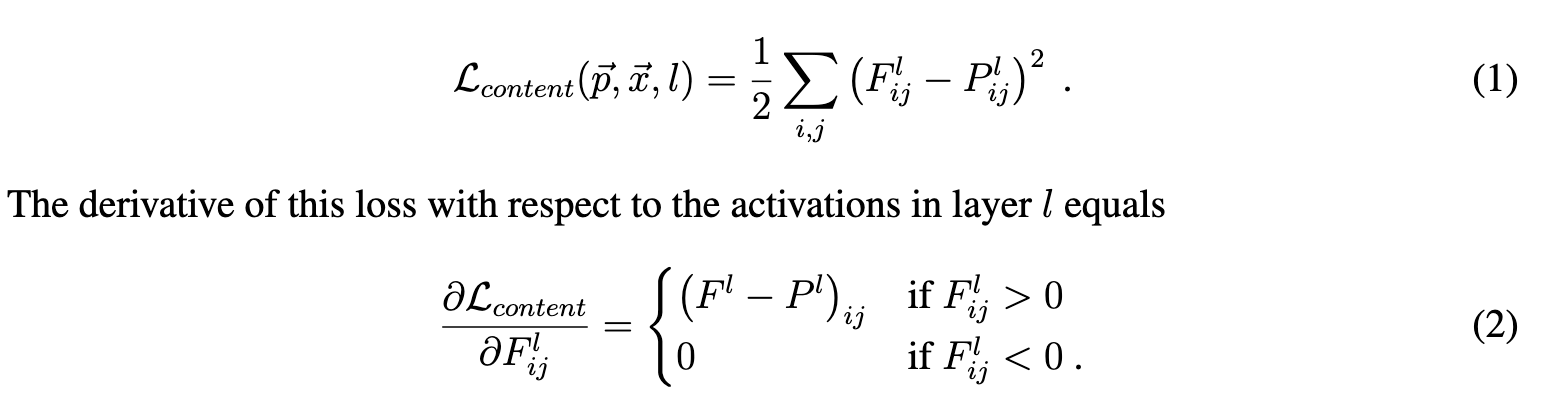

In [178]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# 2.   Style Loss
  Calculated the Style loss, which requires Gram-matrix which is basically multiplying the matrix with its transpose

  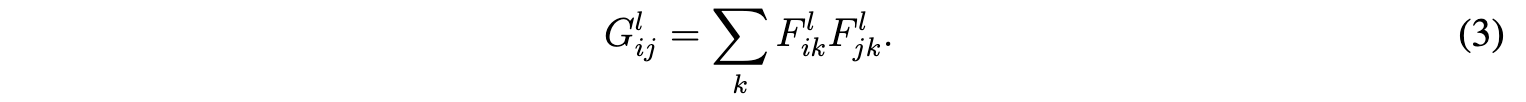
  
  for the same we need to calculate the Lstyle and the total style loss is calculated with the equation

  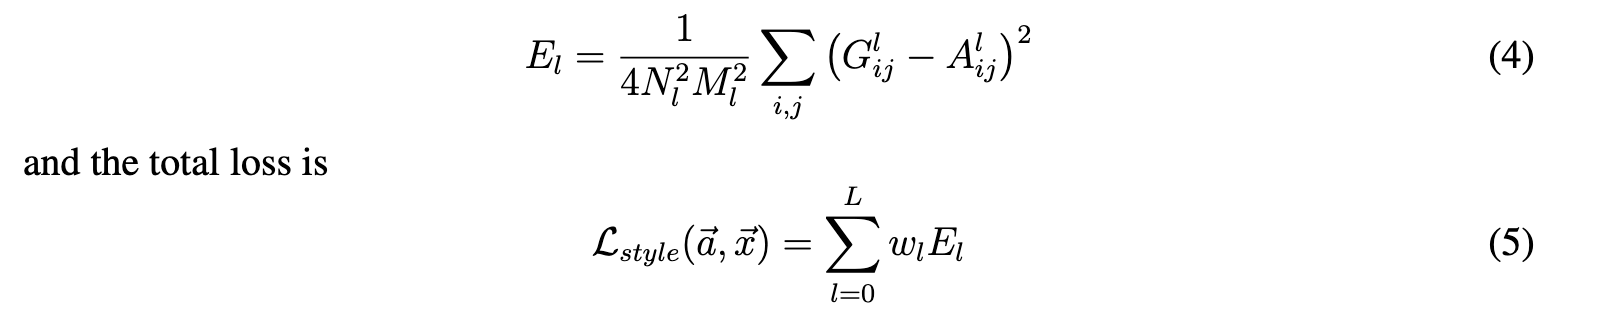

In [164]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [165]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Normalisation
From the paper it is clear that more efficient normalization is by MSE(Mean Square Error) it is calculated with mean and standard deviation

In [166]:

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

# Image utils

*   Load Image

    The properties of image should be identical like the height and width, need to select those images which is loaded to the code as tensor using the `transforms` library with the `PIL Image`

*   Show Image

    To show the Image which is currently a tensor uses the same `transforms` library

    
In order to add the dimension to the images the *`unsqueeze(0)`* method is used, which is later reverted using the *`squeeze(0)`*


In [177]:
imsize = 128
device = 'cpu'

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

def image_loader(image_name):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0) # Add dimension
  return image.to('cpu', torch.float)

plt.ion()
unloader = transforms.ToPILImage()
def imshow(tensor, title=None):
  image=tensor.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

# VGG-19

It uses a pretrained model `vgg19` and created a mean and standard deviation with tensor

In [ ]:
cnn = models.vgg19(pretained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485,0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Layers

Creates a default content and style layers which are convolution layers as per paper


and the losess are calculated with the above classes of `StyleLoss` and `ContentLoss` with the `Normalization` parameters previously defined

In [170]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
  

    normalization = Normalization(normalization_mean, normalization_std)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0 
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

# Optimizer

Defining a function for optimizing, From the paper it is clear that using the L-BFGS ie, Limited Memory BFGS makes the Gradient Descent decrease with a faster rate

In [171]:
def get_input_optimizer(input_img):

    optimizer = optim.LBFGS([input_img])
    return optimizer

# Run Style Transfer

* Gradient descent for 500 epochs are defined with the vgg-19 model
* With every epoch(steps) the style_score ie the total_style_loss is calculated along with the total_content_loss

* Which is further multiplied with the style weight and content weight as per paper alpha and beta

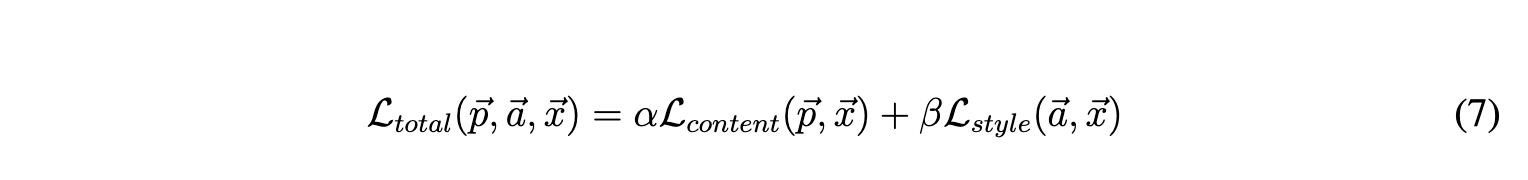


* Within each iteration the optimization step is executed for faster local minima





In [172]:
def run_style_transfer(cnn, norm_mean, norm_std, content_img,
                       style_img, input_img, steps=500,
                       style_weight=1000000, content_weight=1):
  model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                   norm_mean, norm_std,
                                                   style_img, content_img)
  # Important Step
  input_img.requires_grad_(True)
  model.eval()
  model.requires_grad_(False)

  optim = get_input_optimizer(input_img)
  run = [0]
  while run[0] <= steps:
    def closure():
      with torch.no_grad():
          input_img.clamp_(0, 1)

      optim.zero_grad()
      model(input_img)
      style_score =0
      content_score = 0

      for a1 in style_losses:
        style_score += a1.loss

      for c1 in content_losses:
        content_score += c1.loss

      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      loss.backward()

      run[0] += 1
      if run[0] % 50 == 0:
        print('Style loss : {:4f} Content loss: {:4f}'.format(
            style_score.item(), content_score.item()))

      return style_score+content_score

    optim.step(closure)

  with torch.no_grad():
        input_img.clamp_(0, 1)

  return input_img




> To note here is that the input image is used for backpropogation so the model doesn't need to have a grad value which will help to solve the dimension error

---
```
input_img.requires_grad_(True)
model.eval()
model.requires_grad_(False)
```
---







# Loading Images

Images are loaded using the previously defined `image_loader` function, Inorder to save the input image for other styles to be applied we can clone or copy it (optional)

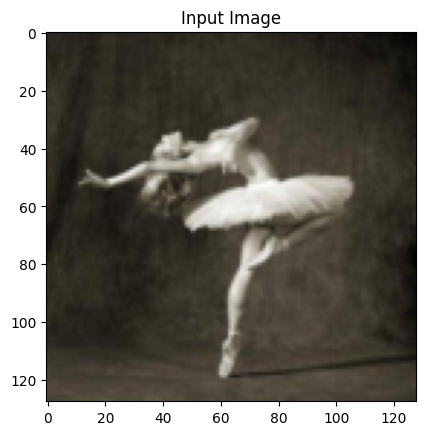

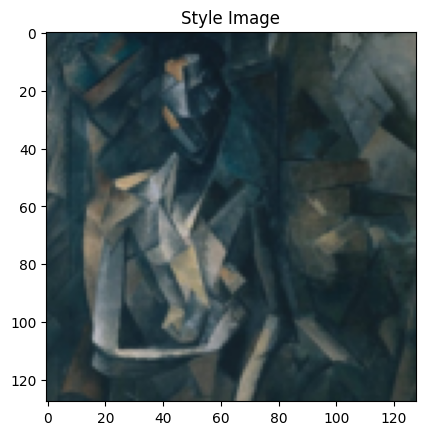

In [179]:
content_img = image_loader("dancing.jpg")
style_img = image_loader("picasso.jpg")

assert style_img.size() == content_img.size(), \
      "we need same size"

input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')
plt.figure()
imshow(style_img, title='Style Image')

# Executing NST



<ipython-input-166-e1259ae66c31>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-166-e1259ae66c31>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Style loss : 26.476486 Content loss: 9.871113
Style loss : 7.033300 Content loss: 8.725686
Style loss : 3.777328 Content loss: 8.008000
Style loss : 2.695870 Content loss: 7.461153
Style loss : 2.212383 Content loss: 7.119155
Style loss : 1.952365 Content loss: 6.905590
Style loss : 1.791167 Content loss: 6.742863
Style loss : 1.678032 Content loss: 6.630303
Style loss : 1.600648 Content loss: 6.543683
Style loss : 1.545539 Content loss: 6.480983


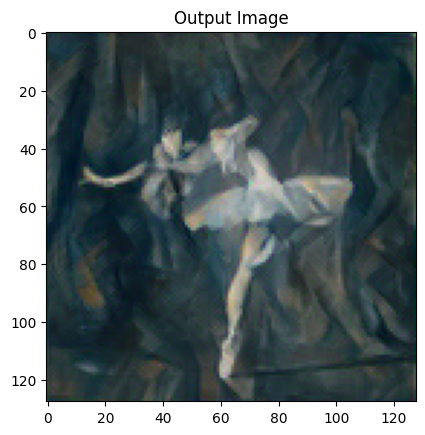

In [174]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()